## Gaussian Mixture Model (Clustering + Density Estimation)

- Pros:
    - Fast
    - Allow ellipsoid cluster boundaries
    - Probabilistic cluster assignment
- Cons:


- GMM = "Extension" of K-Mean. Represent the density as a weighted sum of multi dimentional Gaussian distribution
- Performs better on real-world application that K-Mean


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6) # Change the default value of figsize, default is too small

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

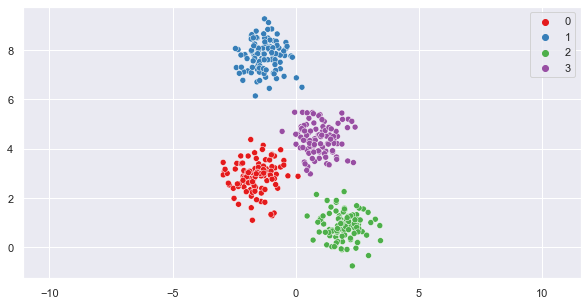

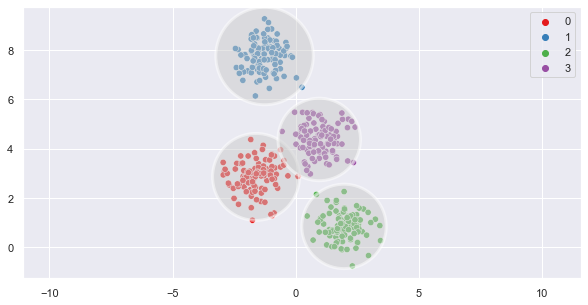

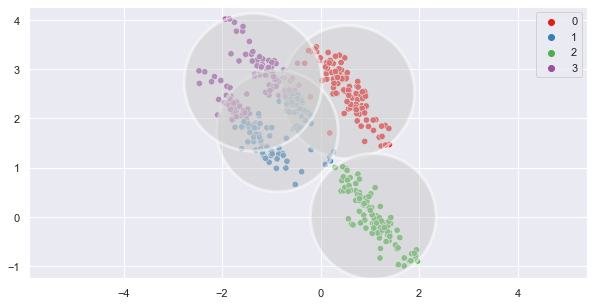

In [2]:
## GMM: Motivation

# K-Means has too many weaknesses

# Generate data
from sklearn.datasets.samples_generator import make_blobs
'''
X, y = make_blobs(n_samples=[20, 180, 50, 50],
                  centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], 
                  cluster_std=0.6,
                  random_state=0)
'''
X, y = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
# Run K-Mean
from sklearn.cluster import KMeans
model = KMeans(4, random_state=0)
clusters = model.fit_predict(X)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim([-5, 5])
ax.set_xlim([-1, 10])
ax.axis("equal")
sns.scatterplot(X[:, 0], X[:, 1], hue=clusters, palette='Set1');

# It seems that the clustering assignment for some points is more certain than others.
# K-Mean has no measure of probability of cluster assigment
# We can think of k-Mean clusters as circles around the cluster centers such that each point in the circle belongs
# to the circle:

from scipy.spatial.distance import cdist

def plot_kmeans(model, X, n_clusters=4, rseed=0, ax=None):
    labels = model.fit_predict(X)
    
    # Plot the input data
    ax = ax or plt.gca()
    ax.axis("equal") # Set the x and y axis such that circle are displayed as circle
    ax = sns.scatterplot(X[:, 0], X[:, 1], hue=labels, s=40, palette='Set1', ax=ax)
    
    # Plot the circles around the cluster centers
    # cdist(XA, XB): Compute distance between each combiination of the points in XA and XB
    centers = model.cluster_centers_
    # For each cluster, compute the distance between the cluster center and its farthest point.
    # It will correspond to the radius of the cluster circle
    cluster_radius = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, cluster_radius):
        # A patch is a 2D Artist
        # (Add visible elements in a figure are subclasses of Artist)
        ax.add_artist(plt.Circle(c, # Center of the circle
                                r, # Radius of the center
                                fc = "#CCCCCC", # facecolor
                                lw=3,
                                alpha = 0.5))
        
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("equal")
model = KMeans(n_clusters=4, random_state=0)
plot_kmeans(model, X)

# Observation: K-Mean clusters are circular due to the distance-based cluster assignement rule.
# K-Mean does not handle elliptical cluster for example (execpt Kernalized K-Mean)

# Let's stretch the datapoints and observe K-Mean clusters
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

model = KMeans(n_clusters=4, random_state=0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("equal")
plot_kmeans(model, X_stretched) 
# -> Circular cluster would be a poor fit.

# Solution: GMM:
# -> Measure uncertainty in cluster assignment by comparing the distances of each points to all centers
# -> Allow cluster boundary to be ellipses

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

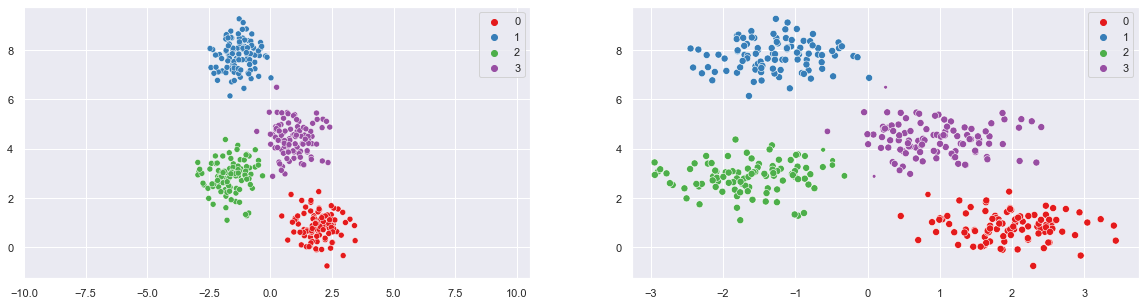

In [3]:
# GMM: Generalizing E-M

# Objective: Find the combination of multi-dimensional Gaussian distribution that best model the dataset
# In the simplest case, GMM behaves like K-Mean

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].axis("equal")
sns.scatterplot(X[:, 0], X[:, 1], hue=labels, palette='Set1', ax=ax[0])

# GMM contains a probabilistic model under the hood, it allows us to find probabilistic cluster assignment
# X has shape (400, 2)
# labels_proba has shape (400, 4): For each sample, the probabilities it belongs to each cluster
labels_proba = gmm.predict_proba(X)
# Make uncertain points smaller
sns.scatterplot(X[:, 0], X[:, 1], hue=labels, s=50 * (labels_proba.max(1))**2, palette='Set1', ax=ax[1])



In [4]:
## GMM steps:
# 1 - Choose initial cluster centers and shape
# 2 - Repeat:
#     E-step: For each point, find weights encoding the probability of membership in each cluster
#     M-step: For each cluster, update its location, normalization and shape based on all data points, 
#             making use of weights

# -> A points never strictly belong to a single cluster, always probabilistic
# -> Each cluster is associated with a smooth Gaussian model.

# Warning: Non-convex -> Can miss the global optimum -> Run it several time with != inital clusters

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


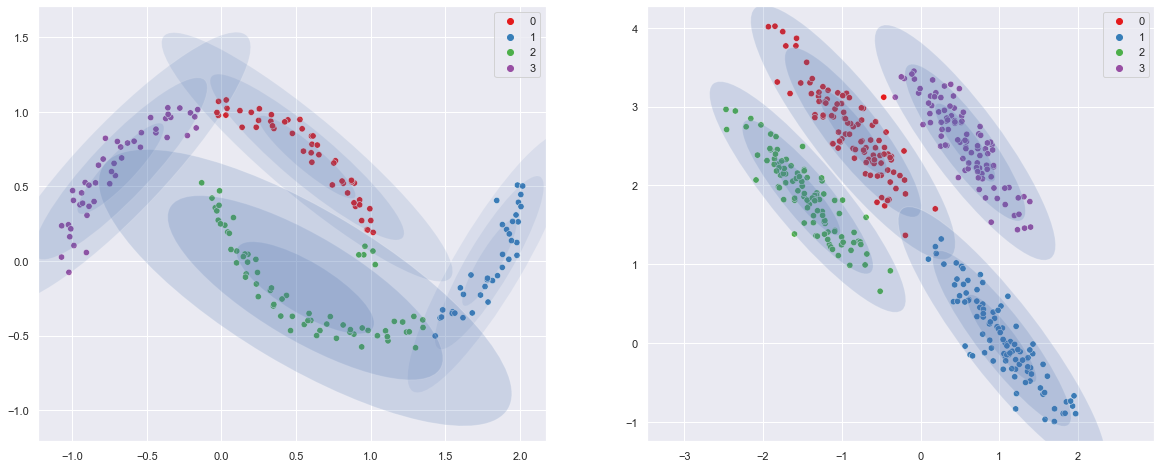

In [36]:
# Define function to represente the GMM clusters shape
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        # Get the Singular Value Decomposition
        # s = vector with the singular values sorted in descending order
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2*np.sqrt(s)
    else:
        if isinstance(covariance, float):
            covariance = np.array([covariance, covariance])
        angle = 0
        width, height = 2*np.sqrt(covariance)
    # Draw the 4 ellipses of different size
    for nsig in range(1, 4):
        ax.add_artist(Ellipse(position, # Ellipse centre
                              nsig*width, # Width
                              nsig*height, # Height
                              angle, # Rotation in degrees anti-clockwise
                              **kwargs
                             ))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    # Train GMM & Get the labels
    labels = gmm.fit_predict(X)
    if label:
        # Visualize the labels with colors
        sns.scatterplot(X[:, 0], X[:, 1], hue=labels, s=40, palette='Set1', ax=ax)
    else:
        # Do not visualize the labels
        sns.scatterplot(X[:, 0], X[:, 1], s=40, palette='Set1', ax=ax)
    ax.axis("equal")
    
    # Plot the cluster ellipses
    # Compute the darkness maximal threshold based on clusters weight (at max it will be alpha = 0.3)
    # The weight is the probability that a new datapoints belong to the cluster
    darkness_factor = 0.2 / gmm.weights_.max() # Take the maximum of the weights of each mixture components
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        # Draw an ellipse to reprent the Gaussian distribution
        draw_ellipse(pos, covar, alpha = w*darkness_factor, ax=ax)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
model = GaussianMixture(n_components=4, # Each component is a different 2D Gaussian distribution
                        covariance_type="full",
                        random_state=42)
plot_gmm(model, X, ax=ax[0])
plot_gmm(model, X_stretched, ax=ax[1])

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

Shape of model.covariances_: 0.48404069438917124
Shape of model.means_: (2,)
Shape of model.covariances_: [0.80780603 0.16027536]
Shape of model.means_: (2,)
Shape of model.covariances_: [[0.80780603 0.207294  ]
 [0.207294   0.16027536]]
Shape of model.means_: (2,)


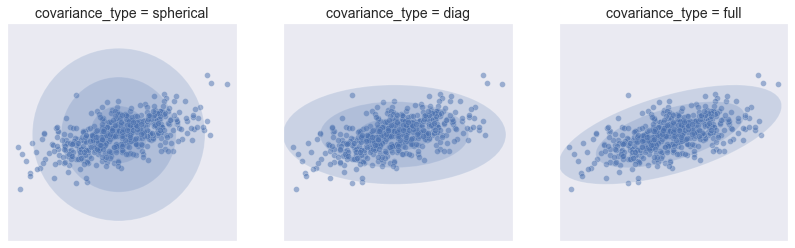

In [24]:
# GMM parameter: "covariance_type"
# covariance_type controls the degrees of freedom in the shape of each cluster

# if covariance_type == "spherical", then the shape of the cluster s.t. all dimension are equal.
#                               -> Ellipse constraint to align the axes (like K-Mean)

# if covariance_type == "diag", then the size of the cluster along each dimension can be set independently
#                               -> Ellipse constraint to align the axes

# if covariance_type == "full", then allow each cluster to be modeled as an ellipse with arbitrary orientation
#                               -> Ellipse constraint to align the axes (like K-Mean)
#                               Set by default, but it is the most computationally expensive

fig, axes = plt.subplots(1, 3, figsize=(14, 4),
                         subplot_kw={"xticks": [], "yticks": []})

# Generate random stretch dataset
rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

for i, cov_type in enumerate(["spherical", "diag", "full"]):
    model = GaussianMixture(n_components=1, # Just one cluster to illustrate the different covariance type shape
                            covariance_type=cov_type).fit(X)
    axes[i].axis("equal")
    # Plot the datapoints
    sns.scatterplot(X[:, 0], X[:, 1], alpha=0.5, ax = axes[i])
    axes[i].set_title(f"covariance_type = {cov_type}", size=14)
    print(f"Shape of model.covariances_: {model.covariances_[0]}")
    print(f"Shape of model.means_: {model.means_[0].shape}")
    draw_ellipse(model.means_[0], model.covariances_[0], ax=axes[i], alpha=0.2)
    

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

<AxesSubplot:>

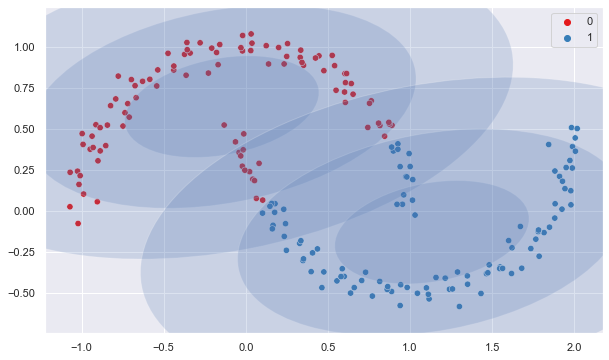

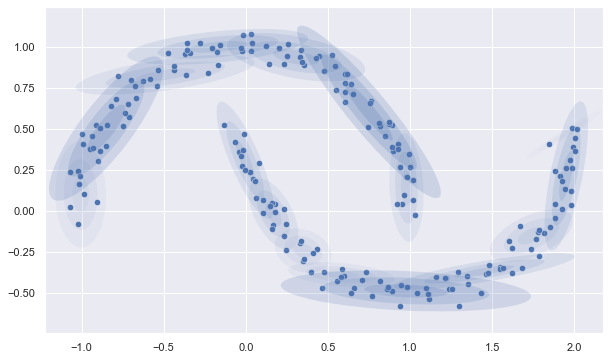

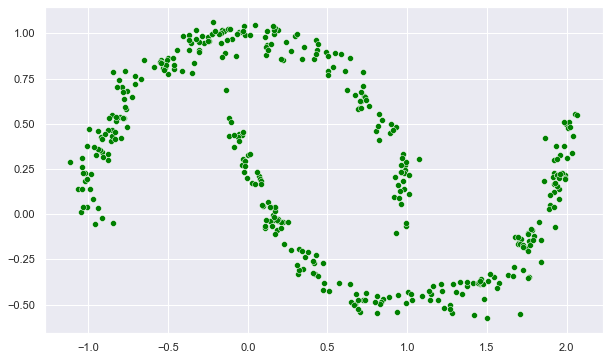

In [58]:
## GMM as "Density Estimation"

# A trained GMM is technically not a clustering algorithm
# but a generative probabilistic model describing the distribution of the data

# Generate data
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200,
                  noise=0.05,
                  random_state=0)


# GMM with 2 clusters
model = GaussianMixture(n_components=2,
                        covariance_type="full",
                        random_state=0).fit(X)
labels = model.predict(X)
plot_gmm(model, X)
# -> GMM not suited for only 2 clusters, even though, by eye, we can identity 2 clusters

# GMM with 16 clusters
fig, ax = plt.subplots()
model = GaussianMixture(n_components=16,
                        covariance_type="full",
                        random_state=0).fit(X)
plot_gmm(model, X, label=False)
# -> GMM with 16 clusters understand the global shape of the data when clusters taken all together
# The 16 clusters does not separate data into 2 clusters, but rather model the overall distribution of the input data.
# So, GMM gives us the recipe to generte new random data distributed similartly to our input

# Let's generate new random datapoint that follow the original distribution
(X_new, y_new) = model.sample(n_samples=400) # Generate 400 random samples from the fitted Gaussian distribution
fig, ax = plt.subplots()
sns.scatterplot(X_new[:, 0], X_new[:, 1], color = 'green')

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


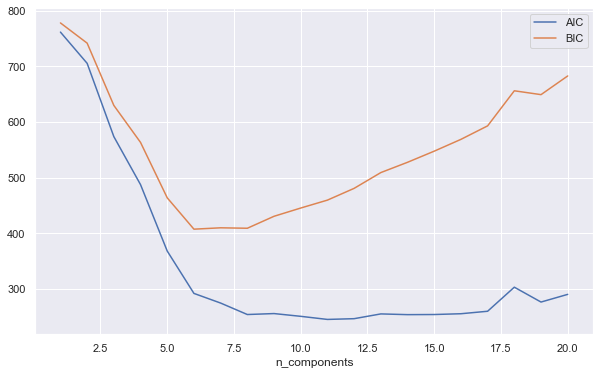

In [69]:
## How many components ?

# Generative model -> Probability distribution of the dataset
# Use cross-validation dataset to avoid overfitting + underfitting ?
# Tools to avoid overfitting: 
# - AIC(Akaike information criterion)
# - BIC (Bayesian information criterion)


# Plot the AIC & BIC as a function of the number of components

# Define our set of GMM to evaluate on the moon dataset
n_components = np.arange(1, 21)
models = [GaussianMixture(n_components=n,
                          covariance_type="full",
                          random_state=0).fit(X) for n in n_components]
# Compute the AIC & BIC
# AIC and BIC are based on the Maximum Likelihood Estimation
# (for which paramters(mu and std), the product of the samples probability is amiximized)
models_aic = [m.aic(X) for m in models]
models_bic = [m.bic(X) for m in models]
sns.lineplot(n_components, models_aic, label="AIC")
ax = sns.lineplot(n_components, models_bic, label="BIC")
ax.set_xlabel("n_components");
# Optimal number of clusters if the value that minimizes the AIC or BIC
# WARING: AIC & BIC help to find the optimal number of clusters as density estimator NOT as a clustering algortihm
# Optimal value is when BIC or AIC are minimal

Data shape: (1797, 64)


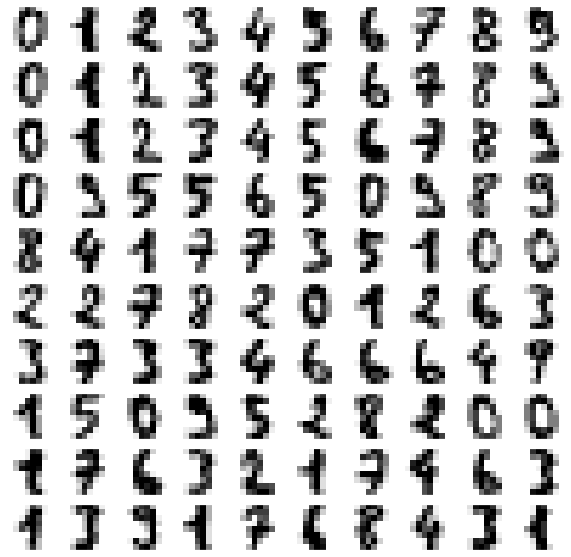

In [81]:
# Example: Generate new handwritten digits

from sklearn.datasets import load_digits
digits = load_digits()
print(f"Data shape: {digits.data.shape}") # n_samples = 1797, n_features = 64. (8x8 image)

# Plot the first images
def plot_digits(data):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10), subplot_kw={"xticks": [],
                                                                   "yticks": []})
    for idx, ax in enumerate(axes.flat):
        ax.imshow(data[idx], cmap='binary')
        
plot_digits(digits.images)

Shape of original data: (1797, 64)
Shape of projected data: (1797, 41)


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=110, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

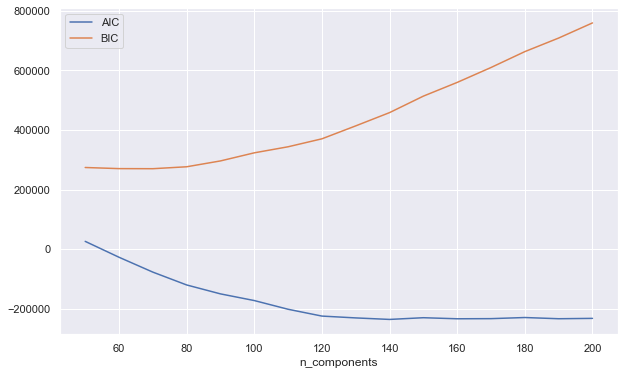

In [111]:
# Apply dimensionality reduction first to speed-up clustering

# WARNING: For PCA to work well, do not forget the preprocess the features to that the mean = 0 and variance = 1
# For images, the feature means and variances are by default similar so this step is "optional"

# PCA with >99% variance kept
from sklearn.decomposition import PCA

X = digits.data
print(f"Shape of original data: {X.shape}")
pca = PCA(0.99, whiten=True)
X_pca = pca.fit_transform(X)
print(f"Shape of projected data: {X_pca.shape}") # -> 41 features instead of 64

# Get the AIC and BIC values of 10 different GMM
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n_components=n,
                          covariance_type='full',
                          random_state=0).fit(X_pca) for n in n_components]
models_aic = [m.aic(X_pca) for m in models]
models_bic = [m.bic(X_pca) for m in models]
sns.lineplot(n_components, models_aic, label="AIC")
ax = sns.lineplot(n_components, models_bic, label="BIC")
ax.set_xlabel("n_components");

# -> Let's choose n_components = 110

Shape of newly generated data: (100, 41)
Shape of newly generated data after inverse PCA: (100, 64)


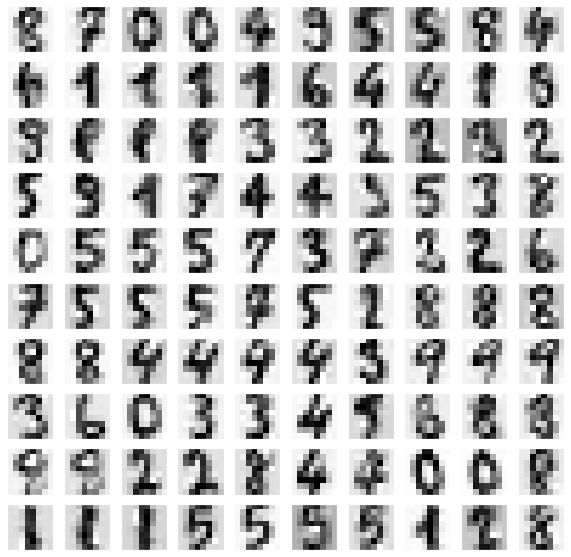

In [120]:
# Draw 100 new samples from our GMM model within the 41 dimension

model = GaussianMixture(n_components=110,
                        covariance_type='full',
                        random_state=0)
model.fit(X_pca)
(X_pca_new, y_pca_new) = model.sample(n_samples=100)
print(f"Shape of newly generated data: {X_pca_new.shape}")

# Transform the new smaples into 8x8 images
X_new = pca.inverse_transform(X_pca_new) # Return an input X_new whose transform would be X_pca_new.
# Each sample in X_pca_new is padded with 0s so that a sample of X_pca_new has 64 features
print(f"Shape of newly generated data after inverse PCA: {X_new.shape}")

# Plot the new samples:
plot_digits(X_new.reshape(X_new.shape[0], 8, 8))

In [ ]:
# Example Summary:

# -> Simply the handwritten images dataset by keeping 41 dimension instead of 64 (PCA)
# -> Learn what would be the best number of components to replicate the dataset distribution (BIC + AIC)
# -> Learn the "best "distribution of the dataset (GMM.fit())
# -> Generate new samples (GMM.sample())
# -> Plot the new samples. Observe that it could have been actual handwritten images

In [101]:
## Whitening: Preprocessing step used for PCA:
# If dataset = images, adjacent pixel values ae highly correlated, so pixels values are redundant
# The goal of "whitening" is to make the images pixels less redundant
# -> Features will be less correlated with each other. Solution: Apply PCA projection (cov(feature_1, feature_2) == 0)
# -> Features all have the same variance: 1. Solution: Scale x_projected by square root of the axis eigenvalue
#    But, if eigenvalue is close to 0, the x_projected value may blow up -> Apply Regularization

# In final, whitening makes the covariance matrix of the final x's_projected equal to identity matrix. (var(feat.1 = 1))

# Reference: http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

#### Concept Summary

- GMM: Ellispoid shape of cluster + Probabilistic cluster assignment.
    - Assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters
    - covariance_type: Controls degree of freedom in the shape of the clusters
    
- Density estimation: GMM serves to model the overall distribution of the input data (generate new random sample that follow the original distribution)
    - AIC & BIC: To find the optimal number of clusters as density estimator not as a clustering algortihm
    
    
- Whitening: Make features less redundance to facilitate clustering